In [16]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import*

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType

In [17]:
# 2. Initializing SparkSession

spark = SparkSession.builder.appName('creditinfo1').getOrCreate()

In [18]:
df_credit = spark.read.json("cdw_sapp_credit.json")


In [19]:
df_credit.show()

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|
|        114|4210653349028689|123459988| 19|    4|             4|   Entertainment|            59.73|2018|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|
|        164|4210653349028689|123459988| 28|    5|             6|       Education|             6.89|2018|
|        119|4210653349028689|123459988| 19|  

In [20]:
df_credit = df_credit.withColumn('YEAR', df_credit['YEAR'].cast('string'))
df_credit = df_credit.withColumn('MONTH', lpad(df_credit['MONTH'], 2, '0'))
df_credit = df_credit.withColumn('DAY', lpad(df_credit['DAY'], 2, '0'))

# df_cust = df_cust.select(df_cust['CUST_PHONE'].cast('string'))
df_credit.printSchema()

root
 |-- BRANCH_CODE: long (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_SSN: long (nullable = true)
 |-- DAY: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- TRANSACTION_ID: long (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: string (nullable = true)



In [21]:
df_credit = df_credit.withColumn('TIMEID', concat(df_credit['YEAR'],df_credit['MONTH'],df_credit['DAY']))


In [22]:
df_credit.show()

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|  TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|        114|4210653349028689|123459988| 14|   02|             1|       Education|             78.9|2018|20180214|
|         35|4210653349028689|123459988| 20|   03|             2|   Entertainment|            14.24|2018|20180320|
|        160|4210653349028689|123459988| 08|   07|             3|         Grocery|             56.7|2018|20180708|
|        114|4210653349028689|123459988| 19|   04|             4|   Entertainment|            59.73|2018|20180419|
|         93|4210653349028689|123459988| 10|   10|             5|             Gas|             3.59|2018|20181010|
|        164|4210653349028689|123459988| 28|   05|             6|       Educatio

In [23]:
df_credit = df_credit.drop('DAY','MONTH','YEAR')
df_credit.show()

+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|  TIMEID|
+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|        114|4210653349028689|123459988|             1|       Education|             78.9|20180214|
|         35|4210653349028689|123459988|             2|   Entertainment|            14.24|20180320|
|        160|4210653349028689|123459988|             3|         Grocery|             56.7|20180708|
|        114|4210653349028689|123459988|             4|   Entertainment|            59.73|20180419|
|         93|4210653349028689|123459988|             5|             Gas|             3.59|20181010|
|        164|4210653349028689|123459988|             6|       Education|             6.89|20180528|
|        119|4210653349028689|123459988|             7|   Entertainment|            43.39|20180519|


In [24]:
df_credit = df_credit.withColumnRenamed('CREDIT_CARD_NO','CUST_CC_NO')



In [25]:
df_credit.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "password") \
  .save()

               


In [26]:
df_new = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_CREDIT_CARD") \
  .option("user", "root") \
  .option("password", "password") \
  .load()

df_new.show()


+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|  TIMEID|
+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|        156|4210653312478046|123455692|         22562|         Grocery|            91.08|20180813|
|        180|4210653342242023|123451310|         45069|           Bills|            77.79|20180315|
|        114|4210653349028689|123459988|             1|       Education|             78.9|20180214|
|        107|4210653342242023|123451310|         45070|      Healthcare|            20.47|20180419|
|         35|4210653349028689|123459988|             2|   Entertainment|            14.24|20180320|
|        114|4210653312478046|123455692|         22563|           Bills|             22.2|20180626|
|         47|4210653312478046|123455692|         22564|         Grocery|            77.54|20180320|


In [27]:
df=df_new.toPandas()

In [29]:
df.head()

,BRANCH_CODE,CUST_CC_NO,CUST_SSN,TRANSACTION_ID,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID
0,156,4210653312478046,123455692,22562,Grocery,91.08,20180813
1,180,4210653342242023,123451310,45069,Bills,77.79,20180315
2,114,4210653349028689,123459988,1,Education,78.90,20180214
3,107,4210653342242023,123451310,45070,Healthcare,20.47,20180419
4,35,4210653349028689,123459988,2,Entertainment,14.24,20180320


In [28]:
df1 = df[['TRANSACTION_TYPE', 'TRANSACTION_VALUE']].groupby(df['TRANSACTION_TYPE']).sum()
#df1.reset_index(inplace=True)


C:\Users\12242\AppData\Local\Temp\ipykernel_5788\2880210620.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df[['TRANSACTION_TYPE', 'TRANSACTION_VALUE']].groupby(df['TRANSACTION_TYPE']).sum()


In [30]:
import matplotlib.pyplot as plt

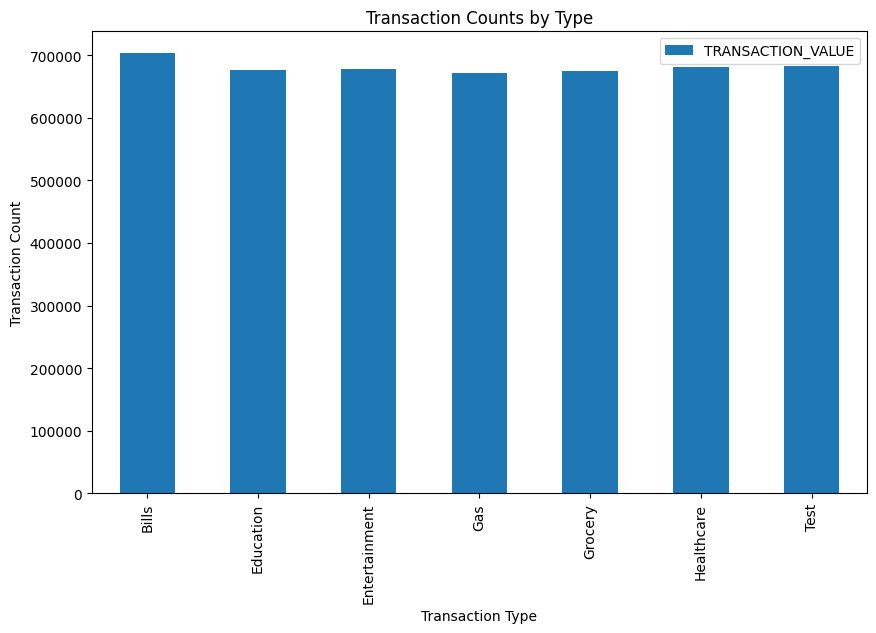

In [31]:
df1.plot(kind='bar', x='TRANSACTION_TYPE', y='TRANSACTION_VALUE',figsize=(10,6))
plt.title('Transaction Counts by Type')
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Count')
plt.show()